# 1. Préparation des données

In [14]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [15]:
import tarfile

def decompress_tar_gz(file_path, destination_dir):
    """
    Décompresse une archive .tar.gz vers un répertoire de destination.

    :param file_path: Chemin complet vers le fichier .tar.gz.
    :param destination_dir: Répertoire où extraire le contenu.
    """

    os.makedirs(destination_dir, exist_ok=True)

    try:
        with tarfile.open(file_path, "r") as tar:
            print(f"Extraction de '{file_path}' vers '{destination_dir}'...")
            tar.extractall(path=destination_dir)
            print("Décompression terminée avec succès.")

    except tarfile.TarError as e:
        print(f"Erreur lors de la décompression du fichier {file_path} : {e}")
    except FileNotFoundError:
        print(f"Erreur : Le fichier spécifié '{file_path}' n'a pas été trouvé.")


In [16]:
from google.colab import drive
drive.mount('/content/drive')

DRIVE_PATH = '/content/drive/MyDrive/Projet_HDDL/'
IMAGE_DIR = os.path.join(DRIVE_PATH, 'images','images')
ANNOTATION_FILE = os.path.join(DRIVE_PATH, 'annotations', 'list_of_files.txt')

print(f"Le répertoire des images est: {IMAGE_DIR}")
print(f"Le fichier d'annotation est: {ANNOTATION_FILE}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Le répertoire des images est: /content/drive/MyDrive/Projet_HDDL/images/images
Le fichier d'annotation est: /content/drive/MyDrive/Projet_HDDL/annotations/list_of_files.txt


In [17]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
DRIVE_PATH = '/content/drive/MyDrive/Projet_HDDL/'
IMAGE_DIR = os.path.join(DRIVE_PATH, 'images', 'images')
ANNOTATION_FILE = os.path.join(DRIVE_PATH, 'annotations', 'list_of_files.txt')

class OxfordDataset(Dataset):
    """
    Jeu de données pour la classification standard (1 image et 1 label par échantillon).
    """
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        # Le dictionnaire {label_index: label_string}
        self.classes = []
        # La liste des tuples (chemin_image_complet, label_index_numerique)
        self.data = self._load_data(annotation_file)

        print(f"Dataset initialisé. Nombre total d'échantillons: {len(self.data)}")


    def _load_data(self, annotation_file):
        """
        Analyse le fichier d'annotation au format Oxford-IIIT Pet (Image CLASS-ID SPECIES BREED ID).
        Utilise le CLASS-ID comme étiquette de classification.
        """
        data_list = []
        # On utilise CLASS-ID (la 2e colonne) comme nom de classe pour le mapping
        label_to_index = {}
        index_counter = 0

        try:
            with open(annotation_file, 'r') as f:
                for line in f:
                    if line.startswith('#') or not line.strip():
                        continue

                    parts = line.strip().split()

                    if len(parts) < 4:
                        print(f"Ligne ignorée (format incorrect): {line.strip()}")
                        continue

                    image_filename = parts[0] + ".jpg"
                    class_id_str = parts[1]


                    # Le CLASS-ID (string) est l'identifiant réel de la classe (ex: '1' à '37')
                    #on map cet identifiant à un index numérique séquentiel (0, 1, 2, ...)
                    if class_id_str not in label_to_index:
                        label_to_index[class_id_str] = index_counter
                        self.classes.append(class_id_str)
                        index_counter += 1

                    label_index = label_to_index[class_id_str]

                    full_image_path = os.path.join(self.image_dir, image_filename)

                    if not os.path.exists(full_image_path):
                         full_image_path = os.path.join(self.image_dir, parts[0])

                         if not os.path.exists(full_image_path):
                            pass

                    data_list.append((full_image_path, label_index))

        except FileNotFoundError:
             print(f"ERREUR: Fichier d'annotation non trouvé à {annotation_file}.")
             return []

        return data_list

    def __len__(self):
        """ Retourne le nombre total d'échantillons. """
        return len(self.data)

    def __getitem__(self, idx):
        """ Récupère un échantillon à l'index donné: (image, label_index). """

        # Récupérer le chemin de l'image et l'index de la classe
        img_path, label_index = self.data[idx]

        # 1. Charger l'image
        image = Image.open(img_path).convert('RGB')

        # 2. Appliquer les transformations
        if self.transform:
            image = self.transform(image)

        # 3. Retourner l'image et l'index de la classe
        return image, torch.tensor(label_index, dtype=torch.long)

In [19]:
from glob import glob
print(f"Recherche des fichiers dans : {IMAGE_DIR}\n")

image_files = []
# Cherche les .jpg (recursive=True permet de chercher dans les sous-dossiers)
image_files.extend(glob(os.path.join(IMAGE_DIR, '**', '*.jpg'), recursive=True))
image_files.extend(glob(os.path.join(IMAGE_DIR, '**', '*.png'), recursive=True))

total_files = len(image_files)
print(f"Nombre total de fichiers image trouvés: **{total_files}**\n")

Recherche des fichiers dans : /content/drive/MyDrive/Projet_HDDL/images/images

Nombre total de fichiers image trouvés: **7390**



In [20]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [21]:
from torch.utils.data import Subset, random_split, DataLoader

DRIVE_PATH = '/content/drive/MyDrive/Projet_HDDL/'
TEST_LIST_DIR = os.path.join(DRIVE_PATH, 'annotations')
IMAGE_DIR = os.path.join(DRIVE_PATH, 'images', 'images')
ANNOTATION_FILE = os.path.join(TEST_LIST_DIR, 'list.txt')
TEST_LIST_FILE = os.path.join(TEST_LIST_DIR, 'test.txt')


def create_data_splits(full_dataset, test_list_path, val_ratio=0.1):
    """
    Sépare le jeu de données en Train/Validation/Test, le Test étant défini
    par un fichier de liste externe au format Oxford-IIIT Pet.
    """

    # Charger les noms des fichiers du jeu de test
    test_filenames = set()
    try:
        with open(test_list_path, 'r') as f:
            for line in f:
                if line.startswith('#') or not line.strip():
                    continue

                parts = line.strip().split()

                if not parts:
                    continue

                image_filename_base = parts[0]
                test_filenames.add(image_filename_base)

    except FileNotFoundError:
        print(f"ERREUR: Fichier de liste de test non trouvé à {test_list_path}. Retourne des Subsets vides.")
        return None, None, None

    test_indices = []
    train_val_indices = []

    for i, (full_path, _) in enumerate(full_dataset.data):
        filename = os.path.basename(full_path)

        filename_base, _ = os.path.splitext(filename)

        if filename_base in test_filenames:
            test_indices.append(i)
        else:
            train_val_indices.append(i)

    print(f"Indices identifiés : Train/Val = {len(train_val_indices)} | Test = {len(test_indices)}")

    if not train_val_indices or not test_indices:
         print("Attention : un ou plusieurs ensembles sont vides. Vérifiez le fichier de test.")

    test_subset = Subset(full_dataset, test_indices)

    #Diviser l'ensemble (Train + Val)
    train_val_size = len(train_val_indices)
    val_size = int(val_ratio * train_val_size)
    train_size = train_val_size - val_size

    train_val_subset = Subset(full_dataset, train_val_indices)

    train_subset, val_subset = random_split(
        train_val_subset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    return train_subset, val_subset, test_subset

In [22]:
# Transformations pour l'entraînement (avec augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Transformations pour la validation et le test (sans augmentation)
eval_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



full_dataset = OxfordDataset(
    image_dir=IMAGE_DIR,
    annotation_file=ANNOTATION_FILE,
    transform=train_transforms
)

#Application de la Division Personnalisée ---
train_subset, val_subset_train_tf, test_subset_train_tf = create_data_splits(
    full_dataset=full_dataset,
    test_list_path=TEST_LIST_FILE,
    val_ratio=0.1
)


#creer une version du Dataset complet avec les transformations d'évaluation
full_dataset_eval = OxfordDataset(
    image_dir=IMAGE_DIR,
    annotation_file=ANNOTATION_FILE,
    transform=eval_transforms
)

# Recréer les Subsets de validation et de test avec les indices d'origine
if val_subset_train_tf and test_subset_train_tf:

    val_indices = val_subset_train_tf.indices
    test_indices = test_subset_train_tf.indices

    val_subset = Subset(full_dataset_eval, val_indices)
    test_subset = Subset(full_dataset_eval, test_indices)
else:
    val_subset, test_subset = None, None

batch_size = 32

if train_subset and val_subset and test_subset:
    # Train DataLoader (avec TRAIN_TRANSFORMS + mélange)
    train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, pin_memory=True)

    # Validation DataLoader (avec EVAL_TRANSFORMS + pas de mélange)
    val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # Test DataLoader (avec EVAL_TRANSFORMS + pas de mélange)
    test_dataloader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, pin_memory=True)

    print("\n--- DataLoaders Créés avec Succès ---")
    print(f"Train Samples: {len(train_subset)} ({len(train_dataloader)} batches) - Transformations d'entraînement.")
    print(f"Validation Samples: {len(val_subset)} ({len(val_dataloader)} batches) - Transformations d'évaluation.")
    print(f"Test Samples: {len(test_subset)} ({len(test_dataloader)} batches) - Transformations d'évaluation.")
else:
     print("Échec de la création des DataLoaders en raison d'une erreur dans la division des données.")

Dataset initialisé. Nombre total d'échantillons: 7349
Indices identifiés : Train/Val = 3680 | Test = 3669
Dataset initialisé. Nombre total d'échantillons: 7349

--- DataLoaders Créés avec Succès ---
Train Samples: 3312 (104 batches) - Transformations d'entraînement.
Validation Samples: 368 (12 batches) - Transformations d'évaluation.
Test Samples: 3669 (115 batches) - Transformations d'évaluation.


## PARTIE 1 : Pretraitement
### Vérification des maques

Dans cette partie on va vérifier la qualité des masques notamment si la base de données en manque pour quelques photot, si leurs tailles est conformes aux photos correspondantes et s'il existe des maques corrompus, i.e s'ils contienntent des valeurs non conformes. Pour rappel, tous les maques ne doivent contenir que les valeurs 1, 2 et 3. 1 pour l'avant plan (i.e le motif d'intérêt, dans ce contexte le chat ou le chien) , 2 pour l'arrière plan et 3 pour le contour fin du masque.

In [23]:
TRIMAP_DIR = os.path.join(DRIVE_PATH, 'annotations', 'trimaps')


def verify_segmentation_masks(full_dataset, trimap_dir=TRIMAP_DIR, sample_size=50):
    """
    Vérifie la cohérence et la qualité des masques de segmentation
    en utilisant full_dataset.data (list of (image_path, label)).
    """

    print("Début de la vérification des masques")

    missing_masks = []
    bad_sizes = []
    bad_values = []

    #on tire aléatoirement 50 images
    dataset_size = len(full_dataset.data)
    indices_to_test = np.random.choice(dataset_size, size=min(sample_size, dataset_size), replace=False)

    for idx in indices_to_test:
        img_path, _ = full_dataset.data[idx]
        img_name = os.path.basename(img_path)
        img_base = os.path.splitext(img_name)[0]

        mask_path = os.path.join(trimap_dir, img_base + ".png")

        #Vérifier existence du masque
        if not os.path.exists(mask_path):
            missing_masks.append(mask_path)
            continue

        img = np.array(Image.open(img_path))
        mask = np.array(Image.open(mask_path))

        #Vérifier dimensions
        if img.shape[0] != mask.shape[0] or img.shape[1] != mask.shape[1]:
            bad_sizes.append((img_name, img.shape, mask.shape))

        #Vérifier valeurs du masque
        unique_vals = set(np.unique(mask))
        if not unique_vals.issubset({1, 2, 3}):
            bad_values.append((img_name, unique_vals))

    print(f"\nMasques manquants : {len(missing_masks)}")
    print(f"Bad sizes : {len(bad_sizes)}")
    print(f"Bad values : {len(bad_values)}")

    # Affichage des erreurs
    if missing_masks:
        print("\nExemples de masques manquants :", missing_masks[:5])
    if bad_sizes:
        print("\nExemples de masques avec mauvaise taille :", bad_sizes[:5])
    if bad_values:
        print("\nExemples de masques avec valeurs incorrectes :", bad_values[:5])

    print("\n=== Vérification terminée ===")



### Visualisation image+masque

In [24]:
def show_image_and_mask(full_dataset, index=0, trimap_dir=TRIMAP_DIR):
    img_path, _ = full_dataset.data[index]
    img_name = os.path.basename(img_path)
    img_base = os.path.splitext(img_name)[0]
    mask_path = os.path.join(trimap_dir, img_base + ".png")

    img = np.array(Image.open(img_path))
    mask = np.array(Image.open(mask_path))

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Image : {img_name}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.title(f"Mask : {img_base}.png")
    plt.axis("off")
    plt.show()


Début de la vérification des masques

Masques manquants : 0
Bad sizes : 0
Bad values : 0

=== Vérification terminée ===


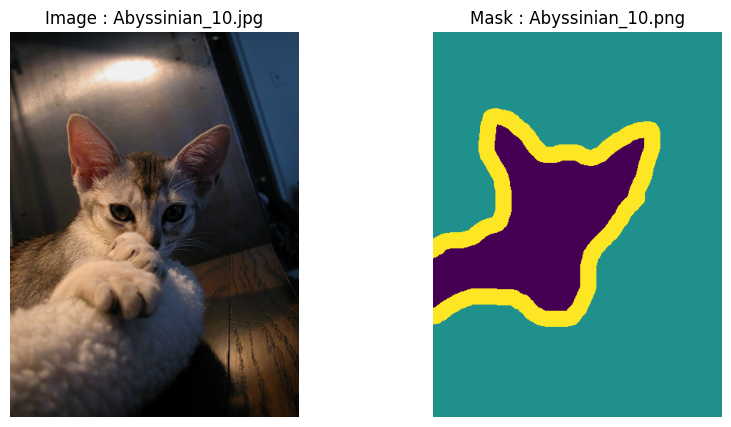

In [25]:
import numpy as np
verify_segmentation_masks(full_dataset)
show_image_and_mask(full_dataset, index=10)


Toutes les photos ont bien un masque qui est de taille et de tailles conformes.

### Désiquilibre/biais

On étudie si le dataset est mal répartie entre les chats/chien et entre les races pour vérifier s'il y a un déséquilibre avant de commencer l'entraînement des modèles.

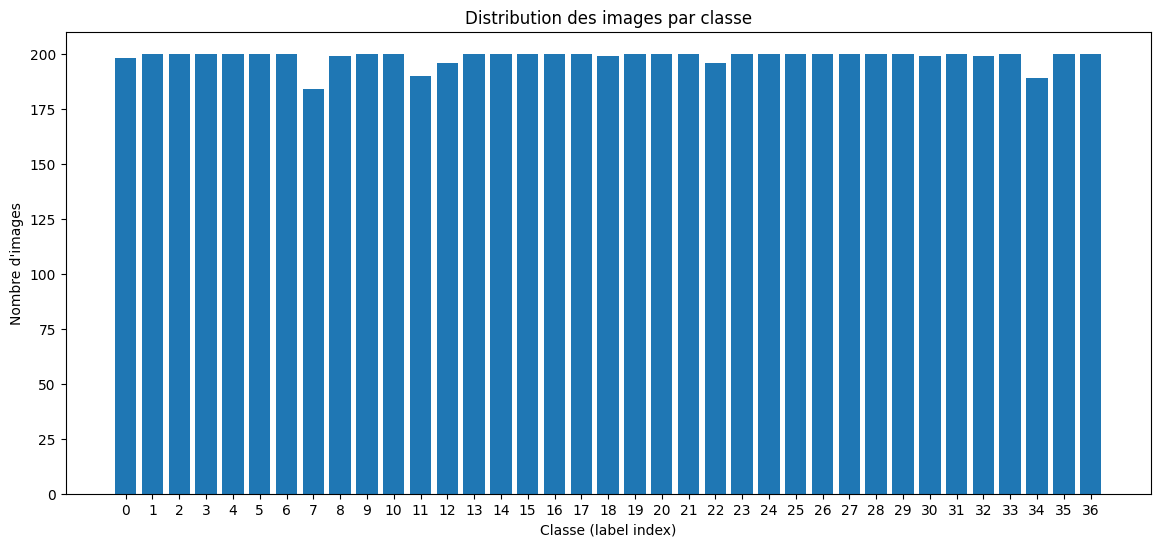

In [26]:
from collections import Counter

def count_images_per_class(full_dataset):
    labels = [label for _, label in full_dataset.data]

    counts = Counter(labels)

    class_ids = sorted(counts.keys())
    class_counts = [counts[c] for c in class_ids]

    plt.figure(figsize=(14,6))
    plt.bar(class_ids, class_counts)
    plt.xticks(class_ids)
    plt.title("Distribution des images par classe")
    plt.xlabel("Classe (label index)")
    plt.ylabel("Nombre d'images")
    plt.show()

    return counts

counts = count_images_per_class(full_dataset)


Visuellement il y a un légér déséquilibre d'environ 20 photo qui concerne 5 races qui sont 7- Bombay (chat), 11-Egyptian Mau (chat), 12-English Cocker Spaniel (chien), 22-Newfoundlander (chien), 34-Thai (chat). Sachant qi'il y a seulement 12 classes de chat contre 25 pour chien, il peut y avoir un désavantage dans la classification des chat surtout pour les races dont le nombre d'images par classe manque par rapport aux autres races de chien.

On verra plus tard si ce désiquilibre peut créer des erreurs de classification pour les animaux/races concernés.


### Analyse de biais
À part le déséquilibre des classes, plusieurs d'autres facteurs peuvent biaiser la base de données.

Analyse de luminosité

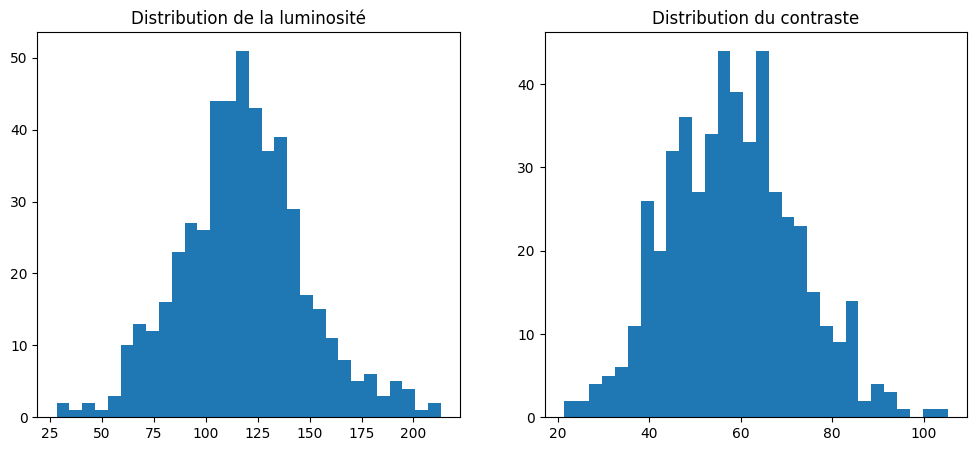

In [27]:
def analyze_brightness_contrast(full_dataset, sample_size=500):
    brightness_vals = []
    contrast_vals = []

    indices = np.random.choice(len(full_dataset.data), size=min(sample_size, len(full_dataset.data)), replace=False)

    for idx in indices:
        path, _ = full_dataset.data[idx]

        img = np.array(Image.open(path).convert("L"))  # Niveaux de gris

        brightness_vals.append(img.mean())
        contrast_vals.append(img.std())

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.hist(brightness_vals, bins=30)
    plt.title("Distribution de la luminosité")

    plt.subplot(1,2,2)
    plt.hist(contrast_vals, bins=30)
    plt.title("Distribution du contraste")

    plt.show()

    return brightness_vals, contrast_vals

brightness_vals, contrast_vals = analyze_brightness_contrast(full_dataset)


**Analyse de luminosité :**
La distribution de la luminosité des images est quasi-normale pour l'ensemble de données. Ce qui signifie que les images sont globalement cohérentes en termes d'exposition, et qu'il y a très peu d'images ayant une luminosité extrême. On observe un pic dans le nombre d'images ayant une moyenne de luminosité de 130. Il est quand même important d'avoir quelques cas aberrants pour tester la performance et la robustesse des modèles de classification.

**Analyse de contrast :**
La distribution du contraste des images est elle aussi quasi-normale. Il y a donc peu d'images ayant un contraste extrême, que ce soit des images trop ternes ou au contraire très contrastées. L'analyse montre un pic du nombre d'images ayant une moyenne de contraste autour de 60. Globalement, le dataset est donc de bonne qualité en termes de netteté et d'exposition.

### Analyse de couleur (teintes dominantes)
Des couleurs qui sont souvent présnetes dans le dataset peuvent énormément biaiser l'entraînement des modèles. 

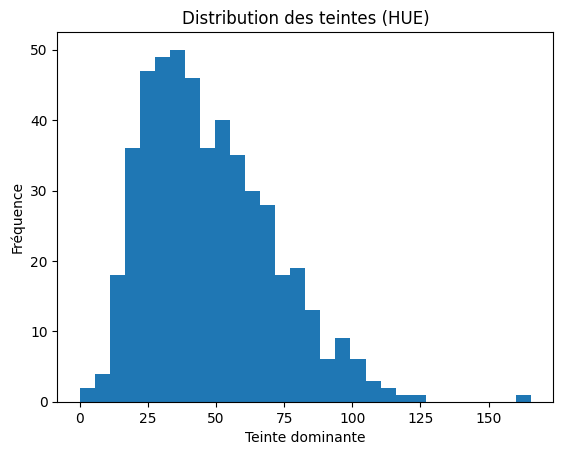

In [28]:
import cv2

def analyze_color_distribution(full_dataset, sample_size=500):

    hues = []

    idxs = np.random.choice(len(full_dataset.data), min(sample_size, len(full_dataset.data)), replace=False)

    for idx in idxs:
        path, _ = full_dataset.data[idx]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hue = img[:,:,0].mean()
        hues.append(hue)

    plt.hist(hues, bins=30)
    plt.title("Distribution des teintes (HUE)")
    plt.xlabel("Teinte dominante")
    plt.ylabel("Fréquence")
    plt.show()

analyze_color_distribution(full_dataset)


L'analyse des couleurs montre que l'ensemble de données est dominé par des couleurs plutôt chaudes. On observe un premier pic de ces couleurs chaudes qui représentent potentiellement les couleurs des chats et des chiens eux-mêmes. Le pic le plus important est cependant celui des couleurs jaune/vert, qui représentent probablement les arrière-plans communs, comme les pelouses et les arbres. 

### Analyse des orientations
Une dernière vérification sur le jeu de données sera faite sur la prise des images et donc leur orientations.

In [29]:
def analyze_orientations(full_dataset):
    portrait = 0
    landscape = 0

    for path, _ in full_dataset.data:
        img = Image.open(path)
        w, h = img.size
        if h > w:
            portrait += 1
        else:
            landscape += 1

    print("Portrait :", portrait)
    print("Landscape :", landscape)

analyze_orientations(full_dataset)


Portrait : 2361
Landscape : 4988


Près de 2/3 des images sont en format paysage ce qui peut entraîner un biais significatif en faveur de l'orientation paysage.

PARTIE 2 : Classification binaire

## Partie 3 : Classification fine

### 3.1 Baseline

Réflexion: On commence par un modèle from scratch d'architecture plutôt simple afin de comprendre les enjeux et la difficulté de la classification fine.

L'architecture du modèle est composée par 3 blocs contenant chacun une convolution 2D une normalisation pour que les valeurs restent dans la même plage une fonction d'activation Relu pour introduite de la non linéarité dans le modèle et une couche MaxPool pour réduire la taille de l'image et donc réudire le temps de calcul.



In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    """
    Architecture baseline très minimaliste (inspirée de LeNet/AlexNet peu profond).
    Ce modèle sert à établir la référence initiale.
    """
    def __init__(self, num_classes=37):
        super(SimpleCNN, self).__init__()

        # Bloc 1
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # Bloc 2
        self.features2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # Bloc 3
        self.features3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, num_classes),
        )


    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = self.features3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.classifier(x)
        return x

**Justification des choix des hyperparamètres**
Initialement, un taux d'apprentissage de 0.001 avec l'optimiseur Adam a été testé sur le modèle de base, mais a entraîné une instabilité et une très faible convergence.

Par conséquent, le taux d'apprentissage a été réduit à 0.0001 pour s'assurer que l'optimiseur ne saute pas par dessus le minimum de la fonction de perte. Pour maintenir la convergence même après cette stabilisation initiale, le Scheduler ReduceLROnPlateau est ajouté. Ce paramètre surveille la précision de validation et, si aucune amélioration n'est observée pendant une patience de 5 épochs, il réduit automatiquement le taux d'apprentissage par un facteur de 0.1.

Le choix de nombre d'epochs sera discuté dans la suite en observant les courbes des loss.

CrossEntropy: choix automatique pour la classification.

In [32]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


#Définition des hyperparamètres
learning_rate = 0.0001
num_epochs = 15
num_classes = 37

criterion = nn.CrossEntropyLoss()

model_baseline = SimpleCNN(num_classes=num_classes)

optimizer = optim.Adam(model_baseline.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

print(f"Hyperparameters defined: learning_rate={learning_rate}, num_epochs={num_epochs}")
print("Loss function (criterion) initialized.")
print("Optimizer (Adam) initialized for model_baseline.")

Hyperparameters defined: learning_rate=0.0001, num_epochs=15
Loss function (criterion) initialized.
Optimizer (Adam) initialized for model_baseline.


In [33]:
#Definition des classe d'Entrainement + evaluation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model_baseline.to(device)
print("Model moved to device.")

def train_epoch(model, dataloader, criterion, optimizer):
    """
    Performs a single training epoch.
    """
    model.train()
    running_loss = 0.0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def evaluate_model(model, dataloader, criterion):
    """
    Evaluates the model on a given dataloader (validation or test set).
    """
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

print("Training and evaluation functions 'train_epoch' and 'evaluate_model' are defined.")


Using device: cuda
Model moved to device.
Training and evaluation functions 'train_epoch' and 'evaluate_model' are defined.


In [34]:
import time


# --- Initialisation des listes pour l'enregistrement ---
train_losses = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0.0
model_save_path = 'best_simple_cnn_baseline.pth' # Chemin de sauvegarde

print(f"Starting Baseline CNN training loop for {num_epochs} epochs...")

# Boucle d'entraînement principale
for epoch in range(num_epochs):
    start_time = time.time()

    # Entraînement sur l'époque
    epoch_train_loss = train_epoch(model_baseline, train_dataloader, criterion, optimizer)
    train_losses.append(epoch_train_loss)

    # Évaluation de la validation
    epoch_val_loss, epoch_val_accuracy, = evaluate_model(model_baseline, val_dataloader, criterion)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    # Mise à jour du scheduler
    scheduler.step(epoch_val_accuracy)

    end_time = time.time()
    epoch_duration = end_time - start_time

    # Affichage de la progression
    print(f"\nEpoch {epoch+1}/{num_epochs} | Duration: {epoch_duration:.2f}s")
    print(f"  Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_accuracy:.4f}")

    # Sauvegarde du meilleur modèle
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        torch.save(model_baseline.state_dict(), model_save_path)
        print(f"   New best validation accuracy: {best_val_accuracy:.4f}. Model saved.")

print("\nBaseline training complete.")

Starting Baseline CNN training loop for 15 epochs...

Epoch 1/15 | Duration: 46.75s
  Train Loss: 3.4901 | Val Loss: 3.2830 | Val Acc: 0.1196
   New best validation accuracy: 0.1196. Model saved.

Epoch 2/15 | Duration: 41.15s
  Train Loss: 3.1457 | Val Loss: 3.1662 | Val Acc: 0.1332
   New best validation accuracy: 0.1332. Model saved.

Epoch 3/15 | Duration: 40.42s
  Train Loss: 2.9645 | Val Loss: 2.9775 | Val Acc: 0.2092
   New best validation accuracy: 0.2092. Model saved.

Epoch 4/15 | Duration: 40.58s
  Train Loss: 2.8193 | Val Loss: 2.9045 | Val Acc: 0.2201
   New best validation accuracy: 0.2201. Model saved.

Epoch 5/15 | Duration: 40.47s
  Train Loss: 2.7135 | Val Loss: 2.8360 | Val Acc: 0.2391
   New best validation accuracy: 0.2391. Model saved.

Epoch 6/15 | Duration: 40.55s
  Train Loss: 2.6064 | Val Loss: 2.7939 | Val Acc: 0.2391

Epoch 7/15 | Duration: 40.39s
  Train Loss: 2.5189 | Val Loss: 2.6627 | Val Acc: 0.2826
   New best validation accuracy: 0.2826. Model saved.


Le résultat est comme attendu, l'accuracy de validation est plus proche qu'une attribution aléatoire qu'une classification en sortie d'un réseau de neurone. Une approche plus profonde sera établie par la suite parce qu'une simple baseline d'un réseau peu profond est insuffisant pour faire une classification aussi fine.

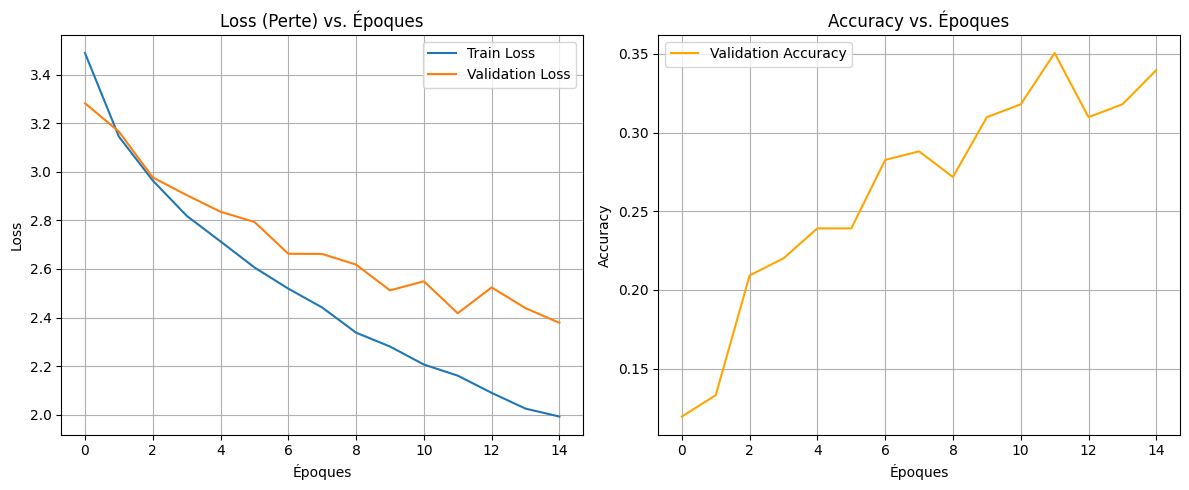

In [35]:
import matplotlib.pyplot as plt

# Création de la figure pour les courbes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss (Perte) vs. Époques')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title("Accuracy vs. Époques")
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Croisement des loss au bout d'un epoch et la loss d'entraîement s'éloigne rapidement de celle de validation ce qui veut dire que le modèle va dépendre fortement des images d'entrainement --> Risque de surapprentissage.

### 3.2 Baseline plus profonde

Ce modèle est basé sur une architecture plus profonde et large que la baseline initiale et a pour objectif d'améliorer l'accuracy. Son architecture contient 3 blocs avec 2 convolutions par bloc afin d'extraire davantage des détails en plus d'une augmentation de canaux (32--> 64). De plus, afin d'éviter le surapprentissage , une couche de Dropout a été ajoutée (la désactication de quelques neurones) sur la première couche linéaire.

In [36]:
# Define a simple CNN model type VGG
class VGGlike(nn.Module):
    def __init__(self, num_classes=37):
        super(VGGlike, self).__init__()

        # --- Bloc 1 (64 canaux) : 2x Conv + Pool ---
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Taille: 224 -> 112

        # --- Bloc 2 (128 canaux) : 2x Conv + Pool ---
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Taille: 112 -> 56

        # --- Bloc 3 (256 canaux) : 2x Conv + Pool ---
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # Taille: 56 -> 28

        # --- Couches FC ---
        # 28 * 28 * 256
        self.fc1 = nn.Linear(256 * 28 * 28, 1024)
        self.dropout = nn.Dropout(0.5) # Ajout de Dropout pour la régularisation
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Bloc 1
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = self.pool1(F.relu(self.bn1_2(self.conv1_2(x)))) # 64 ch, 112x112

        # Bloc 2
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = self.pool2(F.relu(self.bn2_2(self.conv2_2(x)))) # 128 ch, 56x56

        # Bloc 3
        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = self.pool3(F.relu(self.bn3_2(self.conv3_2(x)))) # 256 ch, 28x28

        # Flatten et FC
        x = x.view(-1, 256 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

num_classes = 37
model_vgg = VGGlike(num_classes=num_classes)

print(f"VGG-like model initialized with {num_classes} output classes.")
# print(model_baseline)

VGG-like model initialized with 37 output classes.


In [37]:
#Définition des hyperparamètres
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

learning_rate = 0.0001
num_epochs = 15
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_baseline.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

print(f"Hyperparameters defined: learning_rate={learning_rate}, num_epochs={num_epochs}")
print("Loss function (criterion) initialized.")
print("Optimizer (Adam) initialized for model_baseline.")

Hyperparameters defined: learning_rate=0.0001, num_epochs=15
Loss function (criterion) initialized.
Optimizer (Adam) initialized for model_baseline.


In [38]:
num_classes = 37
model_vgg.to(device) # N'oubliez pas de le mettre sur le device!

# Initialiser les métriques
train_losses = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0.0

model_save_path = 'best_model_vgglike.pth'

print("Starting VGG-like training loop...")

for epoch in range(num_epochs):
    start_time = time.time()

    # Entraînement : Utiliser model_vgg
    epoch_train_loss = train_epoch(model_vgg, train_dataloader, criterion, optimizer)
    train_losses.append(epoch_train_loss)

    # Évaluation : Utiliser model_vgg
    epoch_val_loss, epoch_val_accuracy = evaluate_model(model_vgg, val_dataloader, criterion)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    # Mise à jour du scheduler
    scheduler.step(epoch_val_accuracy)

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f"Epoch {epoch+1}/{num_epochs} | Duration: {epoch_duration:.2f}s")
    print(f"  Train Loss: {epoch_train_loss:.4f}")
    print(f"  Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_accuracy:.4f}")

    # Sauvegarder le meilleur epoch
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        torch.save(model_vgg.state_dict(), model_save_path)
        print(f"  New best validation accuracy achieved: {best_val_accuracy:.4f}. Model saved to {model_save_path}")

print("Training complete.")

Starting VGG-like training loop...
Epoch 1/15 | Duration: 69.45s
  Train Loss: 3.6790
  Val Loss: 3.6585 | Val Acc: 0.0136
  New best validation accuracy achieved: 0.0136. Model saved to best_model_vgglike.pth
Epoch 2/15 | Duration: 70.43s
  Train Loss: 3.6666
  Val Loss: 3.6583 | Val Acc: 0.0163
  New best validation accuracy achieved: 0.0163. Model saved to best_model_vgglike.pth
Epoch 3/15 | Duration: 69.77s
  Train Loss: 3.6791
  Val Loss: 3.6586 | Val Acc: 0.0136
Epoch 4/15 | Duration: 69.21s
  Train Loss: 3.6667
  Val Loss: 3.6589 | Val Acc: 0.0136
Epoch 5/15 | Duration: 69.95s
  Train Loss: 3.6679
  Val Loss: 3.6586 | Val Acc: 0.0136
Epoch 6/15 | Duration: 69.16s
  Train Loss: 3.6738
  Val Loss: 3.6583 | Val Acc: 0.0136
Epoch 7/15 | Duration: 68.96s
  Train Loss: 3.6673
  Val Loss: 3.6575 | Val Acc: 0.0136
Epoch 8/15 | Duration: 69.49s
  Train Loss: 3.6696
  Val Loss: 3.6583 | Val Acc: 0.0136
Epoch 9/15 | Duration: 69.88s
  Train Loss: 3.6636
  Val Loss: 3.6596 | Val Acc: 0.0136

Le fait d'avoir ajouté plus de couche ne permet pas d'apprendre plus efficacement, et le résultat est catastrophique.
--> Approche résiduelle

### 3.3 Blocs résiduels

Plutôt que d’apprendre directement sur une transformation H(x), le réseau apprend sur fonction résiduelle H(x)=F(x)+x qui est beacoup plus simple à optimiser!

In [39]:
#Définir la classe du bloc résiduel

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        #la partie F(x)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        #la partie (x)
        self.shortcut = nn.Sequential()
        # Si les dimensions (taille spatiale ou canaux) changent, on utilise une convolution 1x1
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x) # (x)

        # Calcul de F(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Ajout résiduel : F(x) + x
        out += identity
        out = F.relu(out)
        return out

#créer un réseau profond en utilisant ce blox
class ResNetLike(nn.Module):
    def __init__(self, num_classes=37):
        super(ResNetLike, self).__init__()

        self.in_channels = 64

        # Début du réseau similaire à ResNet
        self.conv_in = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False) # 224 -> 112
        self.bn_in = nn.BatchNorm2d(64)
        self.pool_in = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 112 -> 56

        # Empilement de 3 blocs résiduels
        self.layer1 = self._make_layer(64, 2, stride=1) # 2 blocs de 64 canaux
        self.layer2 = self._make_layer(128, 2, stride=2) # 2 blocs de 128 canaux, réduction spatiale (56 -> 28)
        self.layer3 = self._make_layer(256, 2, stride=2) # 2 blocs de 256 canaux, réduction spatiale (28 -> 14)
        self.layer4 = self._make_layer(512, 2, stride=2) # 2 blocs de 512 canaux, réduction spatiale (14 -> 7)

        # Taille finale avant la couche FC: 512 * 7 * 7
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1)) #Average pooling
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Couches initiales de conv et de pooling
        x = self.pool_in(F.relu(self.bn_in(self.conv_in(x))))

        # Residual blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Global Average Pooling+FC
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

model_resnetlike = ResNetLike(num_classes=num_classes)
print(f"ResNet-like model initialized with {num_classes} output classes.")

ResNet-like model initialized with 37 output classes.


In [40]:
#Définir les hyperparmètres
from torch.optim.lr_scheduler import ReduceLROnPlateau

learning_rate = 0.0001
num_epochs = 15
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_resnetlike.parameters(), lr=learning_rate)

#learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

print(f"Hyperparameters defined: learning_rate={learning_rate}, num_epochs={num_epochs}")
print("Loss function (criterion) initialized.")
print("Optimizer (Adam) initialized for model_resnetlike.")
print("Learning rate scheduler (ReduceLROnPlateau) initialized.")

Hyperparameters defined: learning_rate=0.0001, num_epochs=15
Loss function (criterion) initialized.
Optimizer (Adam) initialized for model_resnetlike.
Learning rate scheduler (ReduceLROnPlateau) initialized.


In [41]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 54.1 MB/s eta 0:00:00


In [42]:
# métriques pour évaluer le modèle
def evaluate_model(model, dataloader, criterion):
    """
    Évalue le modèle sur un jeu de données (validation ou test).
    Retourne la perte moyenne, la précision, un tenseur de toutes les prédictions
    et un tenseur de toutes les vraies étiquettes.
    """

    model.eval()

    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # initialiser les metriques d'évaluation pour la matrice de confusion
    all_preds = []
    all_targets = []

    with torch.no_grad(): # Désactive le calcul des gradients pour l'inférence
        for inputs, targets in dataloader:

            device = next(model.parameters()).device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calcul de la perte
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)

            # Calcul des prédictions
            _, preds = torch.max(outputs, 1)

            # Calcul de la précision
            correct_predictions += (preds == targets).sum().item()
            total_samples += targets.size(0)

            # Matrice de Confusion
            all_preds.append(preds)
            all_targets.append(targets)

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    final_preds = torch.cat(all_preds)
    final_targets = torch.cat(all_targets)

    model.train()

    return avg_loss, accuracy, final_preds, final_targets

In [43]:
#Lancer entrainement ResNet
from torchmetrics import ConfusionMatrix
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model_resnetlike.to(device)
print("ResNetLike model moved to device.")

# initialisez les metriques d'évaluation
train_losses_resnetlike = []
val_losses_resnetlike = []
val_accuracies_resnetlike = []
best_val_accuracy_resnetlike = 0.0

model_save_path_resnetlike = 'best_resnetlike_model.pth'

print("Starting main training loop for ResNetLike model...")

for epoch in range(num_epochs):
    start_time = time.time()

    # train_epoch
    epoch_train_loss = train_epoch(model_resnetlike, train_dataloader, criterion, optimizer)
    train_losses_resnetlike.append(epoch_train_loss)

    # evaluate_model
    epoch_val_loss, epoch_val_accuracy, _, _ = evaluate_model(model_resnetlike, val_dataloader, criterion)
    val_losses_resnetlike.append(epoch_val_loss)
    val_accuracies_resnetlike.append(epoch_val_accuracy)

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f"Epoch {epoch+1}/{num_epochs} | Duration: {epoch_duration:.2f}s")
    print(f"  Train Loss: {epoch_train_loss:.4f}")
    print(f"  Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_accuracy:.4f}")

    if epoch_val_accuracy > best_val_accuracy_resnetlike:
        best_val_accuracy_resnetlike = epoch_val_accuracy
        torch.save(model_resnetlike.state_dict(), model_save_path_resnetlike)
        print(f"  New best validation accuracy achieved: {best_val_accuracy_resnetlike:.4f}. Model saved to {model_save_path_resnetlike}")

print("ResNetLike model training complete.")

Using device: cuda
ResNetLike model moved to device.
Starting main training loop for ResNetLike model...
Epoch 1/15 | Duration: 42.11s
  Train Loss: 3.3721
  Val Loss: 3.6543 | Val Acc: 0.1087
  New best validation accuracy achieved: 0.1087. Model saved to best_resnetlike_model.pth
Epoch 2/15 | Duration: 42.13s
  Train Loss: 2.9898
  Val Loss: 2.9700 | Val Acc: 0.1712
  New best validation accuracy achieved: 0.1712. Model saved to best_resnetlike_model.pth
Epoch 3/15 | Duration: 41.98s
  Train Loss: 2.7129
  Val Loss: 2.8346 | Val Acc: 0.2120
  New best validation accuracy achieved: 0.2120. Model saved to best_resnetlike_model.pth
Epoch 4/15 | Duration: 41.70s
  Train Loss: 2.4928
  Val Loss: 3.3142 | Val Acc: 0.1929
Epoch 5/15 | Duration: 41.91s
  Train Loss: 2.3242
  Val Loss: 3.4588 | Val Acc: 0.1848
Epoch 6/15 | Duration: 41.57s
  Train Loss: 2.1556
  Val Loss: 2.4413 | Val Acc: 0.3071
  New best validation accuracy achieved: 0.3071. Model saved to best_resnetlike_model.pth
Epoch 7

Amélioration nette dans l'accuracy de validation.

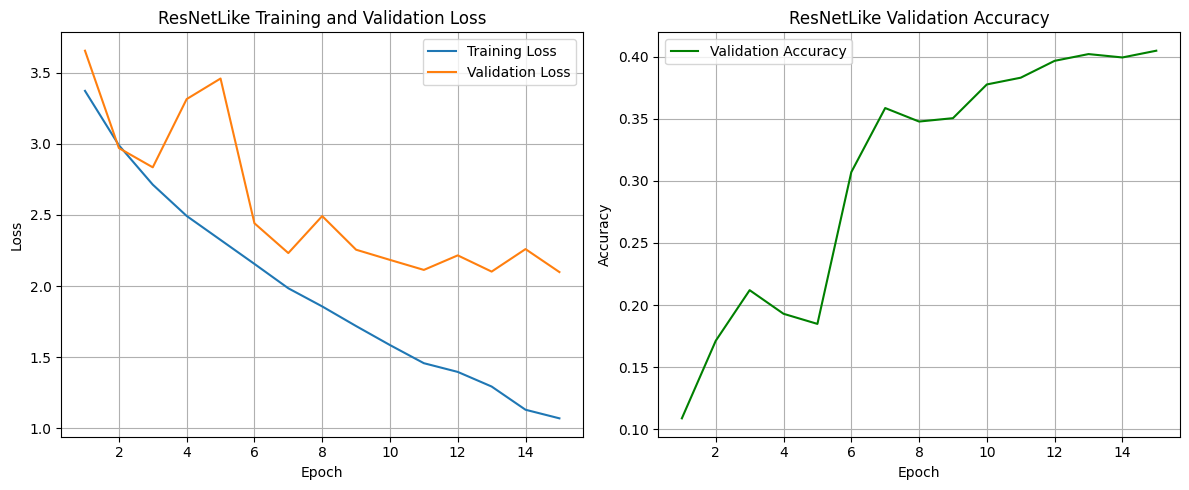

In [44]:
#plot les graphes la loss d'entrainement et de validation et l'accuracy de validation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses_resnetlike, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses_resnetlike, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNetLike Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies_resnetlike, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNetLike Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Toujours le même risque de surapprentissage!

Meilleur modèle chargé depuis best_resnetlike_model.pth sur le périphérique cuda.
--------------------------------------------------
Performance finale sur l'ensemble de TEST :
  Test Loss: 2.4615
  Test Accuracy: 0.3579
--------------------------------------------------


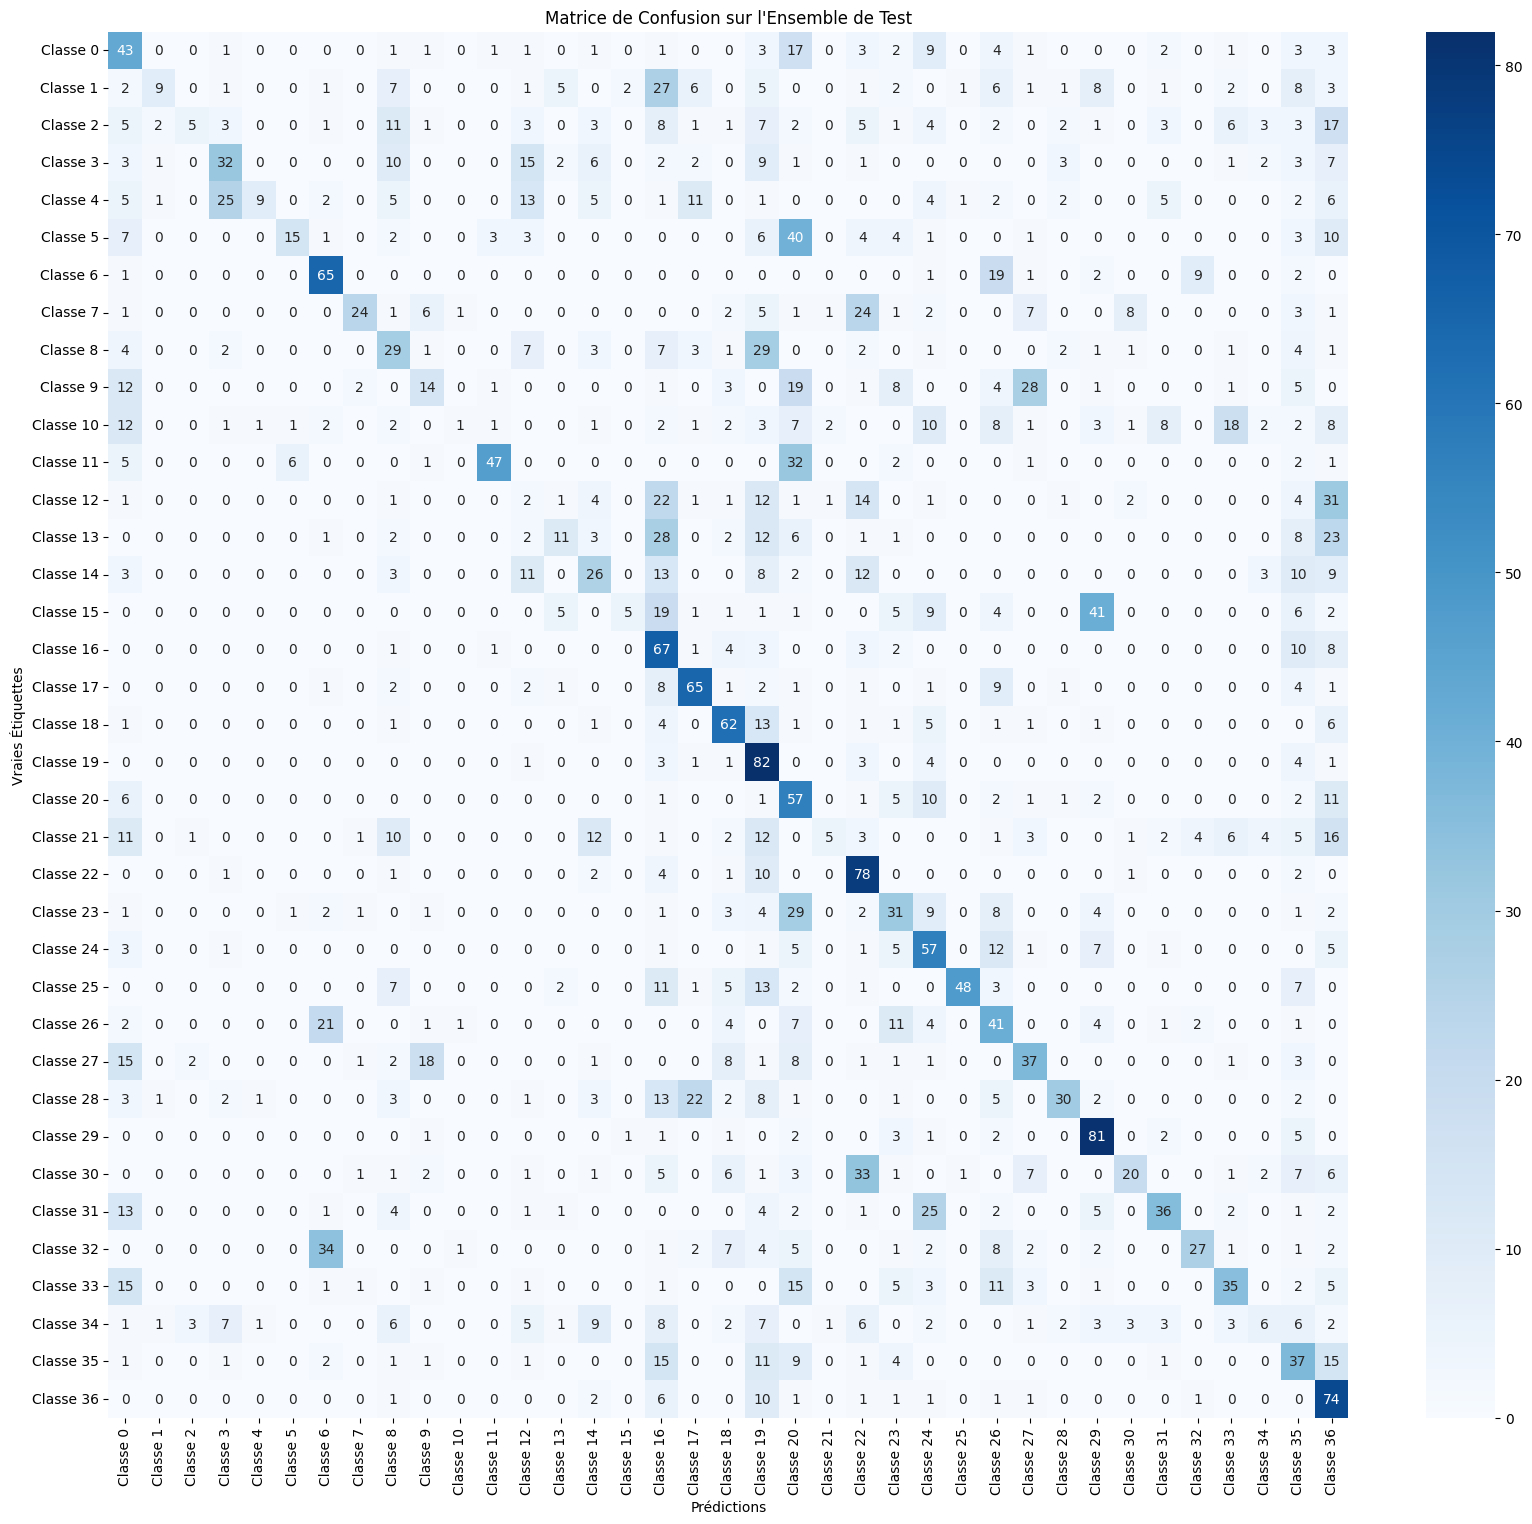

Matrice de confusion tracée.


In [53]:
#tracer ka matrice de confusion
from torchmetrics import ConfusionMatrix


model_save_path_resnetlike = 'best_resnetlike_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

final_model = ResNetLike(num_classes=num_classes)
final_model.load_state_dict(torch.load(model_save_path_resnetlike, map_location=device))
final_model.to(device)
print(f"Meilleur modèle chargé depuis {model_save_path_resnetlike} sur le périphérique {device}.")


test_loss, test_accuracy, test_preds, test_targets = evaluate_model(
    final_model,
    test_dataloader,
    criterion
)

print("-" * 50)
print(f"Performance finale sur l'ensemble de TEST :")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f}")
print("-" * 50)


y_pred = test_preds.cpu()
y_true = test_targets.cpu()

# Initialiser la métrique de matrice de confusion
confmat_metric = ConfusionMatrix(task="multiclass", num_classes=num_classes)
confmat = confmat_metric(y_pred, y_true).numpy()


if 'class_names' not in locals():
    class_names = [f'Classe {i}' for i in range(num_classes)]


plt.figure(figsize=(20, 18))
sns.heatmap(
    confmat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Prédictions')
plt.ylabel('Vraies Étiquettes')
plt.title('Matrice de Confusion sur l\'Ensemble de Test')
plt.show()
print("Matrice de confusion tracée.")

### 3.4 Modèle pré-entraîné
#### 3.4.1 Tranfer learning

Comme les meilleurs résultats sont observés au niveau du modèle résiduel, le choix du modèle pré-entraîné sera le réseau résiduel ResNet18.
Les poids ImageNet permettent de transférer des connaissances génériques apprises sur 1000 classes d'objets. C'est plus efficace que d'apprendre à partir de zéro.

Le leaning rate est de 0.00005 très petit par rapport aux choix précédents et ce parce qu'on entraîne que la dernière couche donc même si cela peut être lent il n'est appliqué qu'en sortie du réseau.

L'optimiseur ne doit cibler que les paramètres de la couche fc (qui sont les seuls à avoir requires_grad=True) pour s'assurer que les poids Imagenet gelés ne sont pas modifiés.

In [46]:
from torchvision import models
#Hyperparamètres pour le Transfer Learning
transfer_learning_lr = 0.00005
num_epochs_tl = 10
print(f"Using device: {device}")

## Charger le modèle ResNet18 pretrained avec les poids imageNet
model_tl = models.resnet18(weights='IMAGENET1K_V1')
print("ResNet18 pré-entraîné sur ImageNet chargé.")

## Geler tous les paramètres
for param in model_tl.parameters():
    param.requires_grad = False
print("Couches de base (features) gelées.")

## Remplacer la dernière couche
num_ftrs = model_tl.fc.in_features
model_tl.fc = nn.Linear(num_ftrs, num_classes)

print(f"Couche de classification remplacée et adaptée à {num_classes} classes.")

model_tl.to(device)
criterion_tl = nn.CrossEntropyLoss()

# On n'entraîne que les paramètres DÉGELÉS
optimizer_tl = optim.Adam(model_tl.fc.parameters(), lr=transfer_learning_lr)

# Le Scheduler au cas où la validatipn stagne
scheduler_tl = ReduceLROnPlateau(optimizer_tl, mode='max', factor=0.1, patience=3)

print("Loss, Optimizer, et Scheduler définis pour le modèle pré-entraîné.")

Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]

ResNet18 pré-entraîné sur ImageNet chargé.
Couches de base (features) gelées.
Couche de classification remplacée et adaptée à 37 classes.
Loss, Optimizer, et Scheduler définis pour le modèle pré-entraîné.


In [47]:
#lancer l'entrainement de ResNet18

#initialiser les meytriques d'évaluation
train_losses_tl = []
val_losses_tl = []
val_accuracies_tl = []
best_val_accuracy_tl = 0.0
model_save_path_tl = 'best_resnet18_transfer_learning_model.pth'

print(f"Starting Transfer Learning training loop for {num_epochs_tl} epochs...")

for epoch in range(num_epochs_tl):
    start_time = time.time()

    #Seule la couche 'fc' est mise à jour
    epoch_train_loss = train_epoch(model_tl, train_dataloader, criterion_tl, optimizer_tl)
    train_losses_tl.append(epoch_train_loss)

    #Évaluation de la validation
    epoch_val_loss, epoch_val_accuracy, _, _ = evaluate_model(model_tl, val_dataloader, criterion_tl)
    val_losses_tl.append(epoch_val_loss)
    val_accuracies_tl.append(epoch_val_accuracy)

    end_time = time.time()
    epoch_duration = end_time - start_time

    # màj du scheduler
    scheduler_tl.step(epoch_val_accuracy)

    print(f"\nEpoch {epoch+1}/{num_epochs_tl} | Duration: {epoch_duration:.2f}s")
    print(f"  Train Loss: {epoch_train_loss:.4f}")
    print(f"  Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_accuracy:.4f}")
    print(f"  Current LR: {optimizer_tl.param_groups[0]['lr']:.6f}")
    if epoch_val_accuracy > best_val_accuracy_tl:
        best_val_accuracy_tl = epoch_val_accuracy
        torch.save(model_tl.state_dict(), model_save_path_tl)
        print(f"   New best validation accuracy: {best_val_accuracy_tl:.4f}. Model saved.")

print("\nTransfer Learning training complete.")

Starting Transfer Learning training loop for 10 epochs...

Epoch 1/10 | Duration: 36.64s
  Train Loss: 3.5988
  Val Loss: 3.3632 | Val Acc: 0.0897
  Current LR: 0.000050
   New best validation accuracy: 0.0897. Model saved.

Epoch 2/10 | Duration: 38.12s
  Train Loss: 3.2488
  Val Loss: 3.0517 | Val Acc: 0.2418
  Current LR: 0.000050
   New best validation accuracy: 0.2418. Model saved.

Epoch 3/10 | Duration: 36.79s
  Train Loss: 2.9636
  Val Loss: 2.7666 | Val Acc: 0.3913
  Current LR: 0.000050
   New best validation accuracy: 0.3913. Model saved.

Epoch 4/10 | Duration: 35.84s
  Train Loss: 2.7076
  Val Loss: 2.5236 | Val Acc: 0.5245
  Current LR: 0.000050
   New best validation accuracy: 0.5245. Model saved.

Epoch 5/10 | Duration: 36.37s
  Train Loss: 2.4722
  Val Loss: 2.2919 | Val Acc: 0.6223
  Current LR: 0.000050
   New best validation accuracy: 0.6223. Model saved.

Epoch 6/10 | Duration: 42.89s
  Train Loss: 2.2728
  Val Loss: 2.1100 | Val Acc: 0.6685
  Current LR: 0.000050


Comme attendu, la précision sur les données de validation sont beacoup mieux (0.4 pour le réseau from scratch contre 0.97 ici). le nombre d'epoch aurait pu être augmenté mais un croisement des loss est observé au niveau de l'epoch 10. 


--- Évaluation Finale du Modèle Pré-entraîné sur l'Ensemble de TEST ---
Best ResNet18 TL model loaded from best_resnet18_transfer_learning_model.pth

ResNet18 TL Model Test Loss: 1.5711
ResNet18 TL Model Test Accuracy: 0.7705

Matrice de Confusion (Tenseur) :
tensor([[43,  1,  0,  ...,  0,  0,  0],
        [ 0, 65, 12,  ...,  4,  0,  0],
        [ 0, 14, 49,  ..., 10,  0,  0],
        ...,
        [ 0,  8, 31,  ..., 25,  0,  0],
        [ 0,  0,  0,  ...,  0, 88,  0],
        [ 0,  0,  0,  ...,  0,  1, 88]], device='cuda:0')


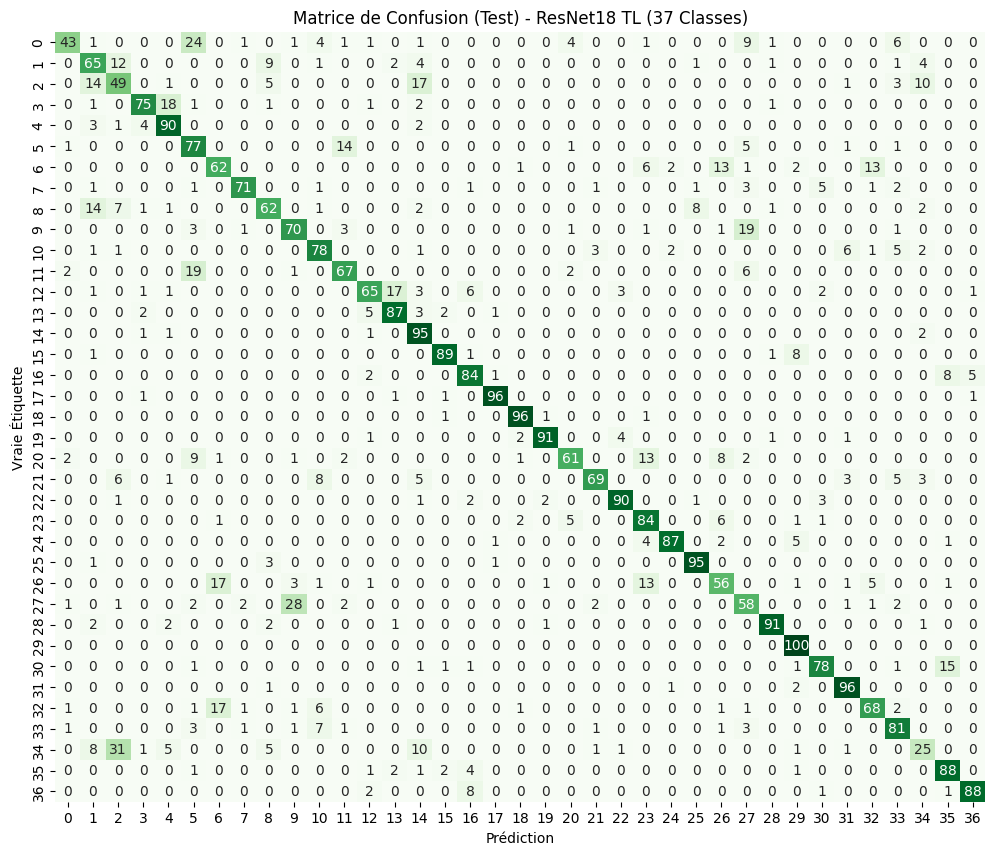

In [48]:
#plot la matrice de confusion
print("\n--- Évaluation Finale du Modèle Pré-entraîné sur l'Ensemble de TEST ---")

model_tl_test = models.resnet18(weights='IMAGENET1K_V1')
for param in model_tl_test.parameters():
    param.requires_grad = False
num_ftrs = model_tl_test.fc.in_features
model_tl_test.fc = nn.Linear(num_ftrs, num_classes)

model_tl_test.load_state_dict(torch.load(model_save_path_tl))
model_tl_test.to(device)
model_tl_test.eval()

print(f"Best ResNet18 TL model loaded from {model_save_path_tl}")

try:
    test_loss_tl, test_accuracy_tl, all_preds_test_tl, all_targets_test_tl = evaluate_model(
        model_tl_test, test_dataloader, criterion_tl
    )

    print(f"\nResNet18 TL Model Test Loss: {test_loss_tl:.4f}")
    print(f"ResNet18 TL Model Test Accuracy: {test_accuracy_tl:.4f}")

    confmat = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)
    conf_matrix_tensor = confmat(all_preds_test_tl, all_targets_test_tl)

    print("\nMatrice de Confusion (Tenseur) :")
    print(conf_matrix_tensor)

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        conf_matrix_tensor.cpu().numpy(),
        annot=True,
        fmt='d',
        cmap='Greens',
        cbar=False
    )
    plt.xlabel('Prédiction')
    plt.ylabel('Vraie Étiquette')
    plt.title(f'Matrice de Confusion (Test) - ResNet18 TL ({num_classes} Classes)')
    plt.show()

except Exception as e:
    print(f"\n Échec de l'évaluation finale ou de la Matrice de Confusion.")
    print(f"Détail de l'erreur: {e}")

Maintenant que le réseau est beacoup plus performant, une analyse sur les résultats peut être faite. les classes les plus confondues sont 28-Russian Blue/10-brotish short hair et 34-stattffordshine bull terrier/3- american pit bull terrier et enfin 1-Abyssinian/ 6-Bengal. des races très proche que même un humain pourrait confondre. 

Il est important aussi de se rappeler du déséquilibre de la base de données en termes de Chat-chien ce qui fait que les confusion les plus importantes sont notés au niveau des chats et aussi le manque léger de la classe 34 observé auparavant.

### 3.5 Fine Tuning

Toujours dans le but d'améliorer l'accuracy, on opte pour un ajustement plus appropié pour la base de données: le fine tuning qui sert cette fois à dégéler plus de couche. le learning rate est forcémennt plus petit afin de détcter davatage les détails que le modèle de transfer learning n'arrivait pas à faire.

Le nombre d'epochs a été augmenté afin de testet si c'est bénéfique (ou pas pour l'entraînement).

Les dernières couches sont souvent celles qui extraient plus de détails, c'est pour cela que ce sont ces couches là qui seront dégélées. Et comme pour la partie de transfer learning la tête du modle es changée pour l'adaoter à 37 et non pour les 1000 classes d'Image Net.

In [49]:
#Définition des hyperparamètres
fine_tuning_lr = 0.000005
num_epochs_ft = 25

model_ft = models.resnet18(weights='IMAGENET1K_V1')

# Geler TOUS les paramètres initialement
for param in model_ft.parameters():
    param.requires_grad = False

# Dégeler les couches de haut niveau (layer4 et layer3)
print("Couches dégélées pour le Fine-Tuning : layer4 et layer3.")
model_ft.layer4.requires_grad_(True)
model_ft.layer3.requires_grad_(True)

## changer la tête de classification
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)


model_ft.to(device)
criterion_ft = nn.CrossEntropyLoss()

# L'Optimizer cible TOUS les paramètres DÉGELÉS (layer4, layer3, et fc)
optimizer_ft = optim.Adam(
    filter(lambda p: p.requires_grad, model_ft.parameters()),
    lr=fine_tuning_lr
)

#Scheduler au cas où la loss stagne
scheduler_ft = ReduceLROnPlateau(optimizer_ft, mode='max', factor=0.1, patience=5)

print("Modèle prêt pour la phase de Fine-Tuning.")

Couches dégélées pour le Fine-Tuning : layer4 et layer3.
Modèle prêt pour la phase de Fine-Tuning.


In [50]:
#Lancer l'entrainement du modele fine-tuné
#Initialiser les metriques d'évaluation
train_losses_ft = []
val_losses_ft = []
val_accuracies_ft = []
best_val_accuracy_ft = 0.0
model_save_path_ft = 'best_resnet18_fine_tuning_model.pth'

print(f"Starting Fine-Tuning training loop for {num_epochs_ft} epochs...")

for epoch in range(num_epochs_ft):
    start_time = time.time()

    #Les couches layer3, layer4 et fc sont mises à jour
    epoch_train_loss = train_epoch(model_ft, train_dataloader, criterion_ft, optimizer_ft)
    train_losses_ft.append(epoch_train_loss)

    #Évaluation de la validation
    epoch_val_loss, epoch_val_accuracy, _, _ = evaluate_model(model_ft, val_dataloader, criterion_ft)
    val_losses_ft.append(epoch_val_loss)
    val_accuracies_ft.append(epoch_val_accuracy)

    end_time = time.time()
    epoch_duration = end_time - start_time

    scheduler_ft.step(epoch_val_accuracy)

    print(f"\nEpoch {epoch+1}/{num_epochs_ft} | Duration: {epoch_duration:.2f}s")
    print(f"  Train Loss: {epoch_train_loss:.4f}")
    print(f"  Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_accuracy:.4f}")
    print(f"  Current LR: {optimizer_ft.param_groups[-1]['lr']:.8f}") # Afficher le LR avec plus de décimales

    if epoch_val_accuracy > best_val_accuracy_ft:
        best_val_accuracy_ft = epoch_val_accuracy
        torch.save(model_ft.state_dict(), model_save_path_ft)
        print(f"   New best validation accuracy: {best_val_accuracy_ft:.4f}. Model saved to {model_save_path_ft}")

print("\nFine-Tuning training complete.")

Starting Fine-Tuning training loop for 25 epochs...

Epoch 1/25 | Duration: 39.72s
  Train Loss: 3.6179
  Val Loss: 3.3423 | Val Acc: 0.1223
  Current LR: 0.00000500
   New best validation accuracy: 0.1223. Model saved to best_resnet18_fine_tuning_model.pth

Epoch 2/25 | Duration: 39.47s
  Train Loss: 3.1805
  Val Loss: 2.9232 | Val Acc: 0.3125
  Current LR: 0.00000500
   New best validation accuracy: 0.3125. Model saved to best_resnet18_fine_tuning_model.pth

Epoch 3/25 | Duration: 39.53s
  Train Loss: 2.7883
  Val Loss: 2.5615 | Val Acc: 0.4701
  Current LR: 0.00000500
   New best validation accuracy: 0.4701. Model saved to best_resnet18_fine_tuning_model.pth

Epoch 4/25 | Duration: 39.62s
  Train Loss: 2.4275
  Val Loss: 2.2381 | Val Acc: 0.5951
  Current LR: 0.00000500
   New best validation accuracy: 0.5951. Model saved to best_resnet18_fine_tuning_model.pth

Epoch 5/25 | Duration: 39.31s
  Train Loss: 2.1205
  Val Loss: 1.9615 | Val Acc: 0.6929
  Current LR: 0.00000500
   New bes


--- Évaluation Finale du Modèle de Fine-Tuning sur l'Ensemble de TEST ---
Meilleur modèle de Fine-Tuning chargé depuis best_resnet18_fine_tuning_model.pth

ResNet18 Fine-Tuning Model Test Loss: 0.6048
ResNet18 Fine-Tuning Model Test Accuracy: 0.8774


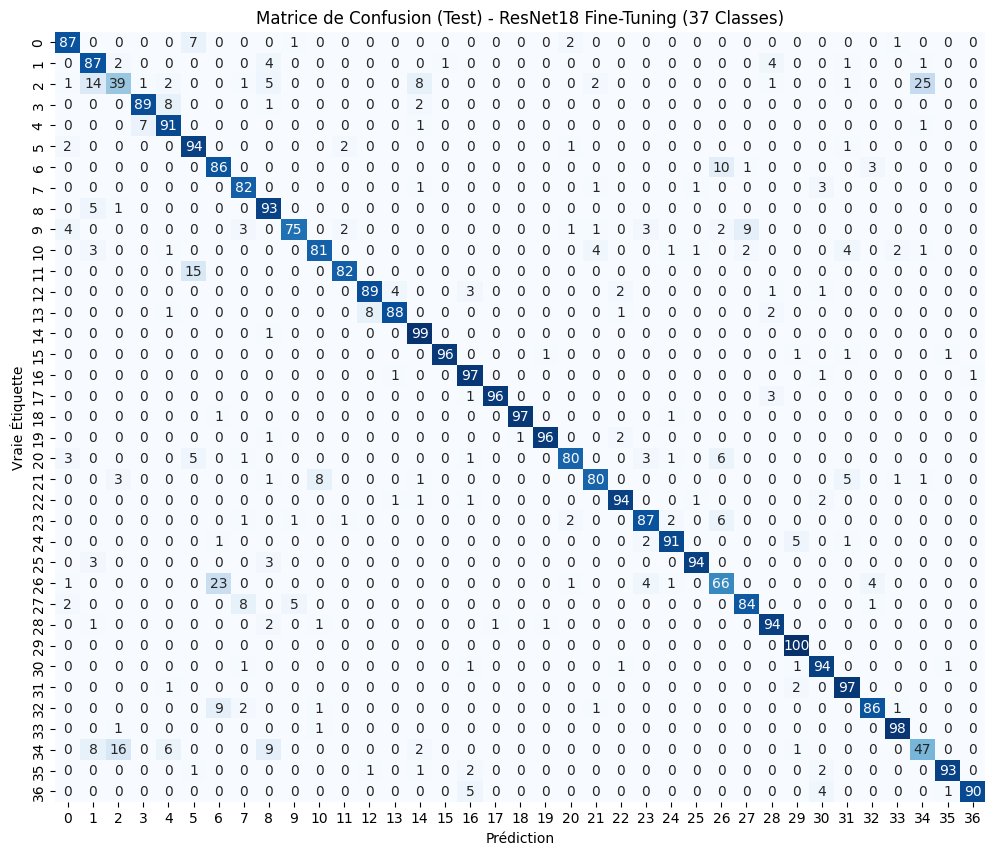

In [51]:
#Matrice de confusion et Loss
model_save_path_ft = 'best_resnet18_fine_tuning_model.pth'

print("\n--- Évaluation Finale du Modèle de Fine-Tuning sur l'Ensemble de TEST ---")

model_ft_test = models.resnet18(weights='IMAGENET1K_V1')

# Appliquer la même stratégie de Gel/Dégel que dans la cellule de configuration
for param in model_ft_test.parameters():
    param.requires_grad = False

model_ft_test.layer4.requires_grad_(True)
model_ft_test.layer3.requires_grad_(True)

num_ftrs = model_ft_test.fc.in_features
model_ft_test.fc = nn.Linear(num_ftrs, num_classes)

try:
    model_ft_test.load_state_dict(torch.load(model_save_path_ft))
    print(f"Meilleur modèle de Fine-Tuning chargé depuis {model_save_path_ft}")
except FileNotFoundError:
    print(f"ERREUR : Fichier modèle non trouvé à {model_save_path_ft}. Assurez-vous que l'entraînement a réussi.")
    exit()

model_ft_test.to(device)
model_ft_test.eval()

try:
    test_loss_ft, test_accuracy_ft, all_preds_test_ft, all_targets_test_ft = evaluate_model(
        model_ft_test, test_dataloader, criterion_ft
    )

    print(f"\nResNet18 Fine-Tuning Model Test Loss: {test_loss_ft:.4f}")
    print(f"ResNet18 Fine-Tuning Model Test Accuracy: {test_accuracy_ft:.4f}")

    confmat = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)
    conf_matrix_tensor = confmat(all_preds_test_ft, all_targets_test_ft)

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        conf_matrix_tensor.cpu().numpy(),
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar=False
    )
    plt.xlabel('Prédiction')
    plt.ylabel('Vraie Étiquette')
    plt.title(f'Matrice de Confusion (Test) - ResNet18 Fine-Tuning ({num_classes} Classes)')
    plt.show()

except Exception as e:
    print(f"\nÉchec de l'évaluation finale ou de la Matrice de Confusion.")
    print(f"Détail de l'erreur: {e}")

Une bonne améliorartion de l'accuracy qui est passé à 0.87 sur les donneés de test. Cependant les classes où on remarquait auparavant sont toujours présents. 

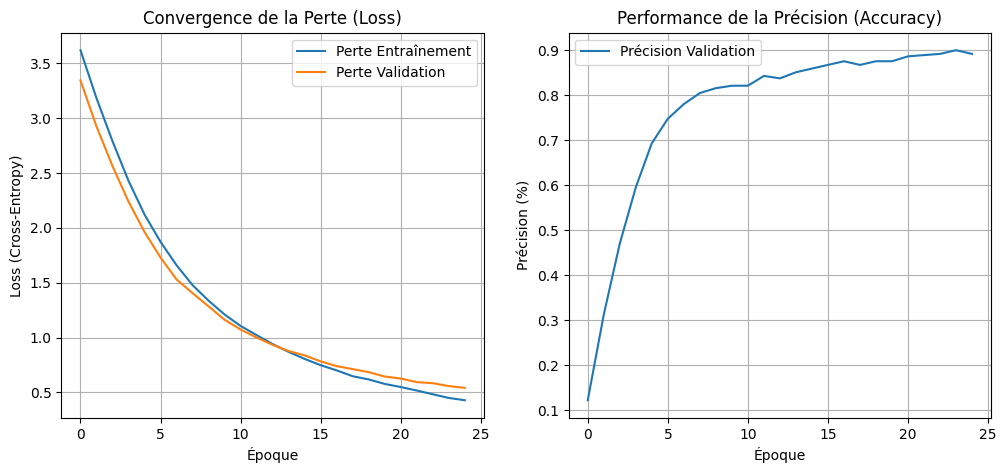

In [52]:
#plot les loss et l'accuracy


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_ft, label='Perte Entraînement')
plt.plot(val_losses_ft, label='Perte Validation')
plt.title('Convergence de la Perte (Loss)')
plt.xlabel('Époque')
plt.ylabel('Loss (Cross-Entropy)')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(val_accuracies_ft, label='Précision Validation')
plt.title('Performance de la Précision (Accuracy)')
plt.xlabel('Époque')
plt.ylabel('Précision (%)')
plt.legend()
plt.grid(True)
plt.show()

Les deux loss se croisent au bout de 12 epochs, on aurait pu donc diminuer le nombre d'epochs.

**Conclusion**
On a commencé avec un modèle très basique (SimpleCNN) mais il n'arrivait pas à apprendre les différences subtiles des races.

On est passé à des architectures plus puissantes comme ResNet pour gérer la complexité et les problèmes de couches profondes et le résulats sur l'accuracy des données de validation.

Le Transfer Learning et le fine tuning a permis de faire un saut d'accuracy où on est passé à quasiment 90% d'accuracy mais il existe toujours des confusion entre des races proches comme les chats gris ou les types de Pit Bull.

Une autre approche de classification multi-tâches sera appliquée par la suite afin de voir si cela permet d'améliorer le résultat de classification fine.